In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linprog

In [3]:
tickers = ["PETR3.SA", "^BVSP", "^GSPC", "VALE3.SA", "ITUB4.SA", "B3SA3.SA"]

In [4]:
data_final = datetime.today()
data_inicial = data_final - timedelta(days=3*365)

dados_mercado = yf.download(tickers, start=data_inicial, end=data_final)
dados_mercado = dados_mercado["Adj Close"]
dados_mercado = dados_mercado.dropna()
dados_mercado.columns = ["B3", "ITAÚ", "PETROBRAS", "VALE", "IBOVESPA", "S&P500"]

[*********************100%%**********************]  6 of 6 completed


In [5]:
dados_mercado

,B3,ITAÚ,PETROBRAS,VALE,IBOVESPA,S&P500
Date,,,,,,
2021-10-19,11.084599,20.752676,11.093968,62.603985,110673.000000,4519.629883
2021-10-20,11.633517,21.306877,11.332135,60.757568,110786.000000,4536.189941
2021-10-21,11.518418,20.872047,10.932630,59.560966,107735.000000,4549.779785
2021-10-22,11.173133,20.070587,10.717511,60.290012,106296.000000,4544.899902
2021-10-25,11.412177,20.462788,11.374390,61.019073,108715.000000,4566.479980
...,...,...,...,...,...,...
2024-10-14,10.880000,34.849998,41.369999,61.930000,131005.000000,5859.850098
2024-10-15,10.840000,35.250000,40.900002,61.169998,131043.000000,5815.259766
2024-10-16,10.980000,35.040001,40.779999,62.340000,131750.000000,5842.470215


In [6]:
# Calcular retornos logarítmicos
retornos = np.log(dados_mercado / dados_mercado.shift(1)).dropna()

# Calcular volatilidade (risco)
volatilidade = retornos.std() * np.sqrt(252)

# Calcular VaR e CVaR
def calcular_var(dados, nivel=0.05):
    var = np.percentile(dados, nivel * 100)
    return var

def calcular_cvar(dados, nivel=0.05):
    var = calcular_var(dados, nivel)
    cvar = dados[dados < var].mean()
    return cvar

var = calcular_var(retornos)
cvar = calcular_cvar(retornos)

print("Retornos Médios:")
print(retornos.mean())
print("\nVolatilidade (Risco):")
print(volatilidade)
print("\nVaR:")
print(var)
print("\nCVaR:")
print(cvar)

Retornos Médios:
B3          -0.000055
ITAÚ         0.000726
PETROBRAS    0.001768
VALE        -0.000046
IBOVESPA     0.000226
S&P500       0.000357
dtype: float64

Volatilidade (Risco):
B3           0.372292
ITAÚ         0.235356
PETROBRAS    0.356947
VALE         0.316501
IBOVESPA     0.177971
S&P500       0.179181
dtype: float64

VaR:
-0.02775148904302463

CVaR:
B3          -0.039468
ITAÚ        -0.036825
PETROBRAS   -0.049554
VALE        -0.037199
IBOVESPA    -0.033835
S&P500      -0.034784
dtype: float64


In [7]:
def otimizar_carteira(retornos, riscos, capacidade):
    c = [-r for r in retornos]
    A = [riscos]
    b = [capacidade]
    resultado = linprog(c, A_ub=A, b_ub=b, bounds=(0, 1))
    return resultado.x

pesos = otimizar_carteira(retornos.mean(), volatilidade, capacidade=0.2)
pesos_percent = [peso * 100 for peso in pesos]

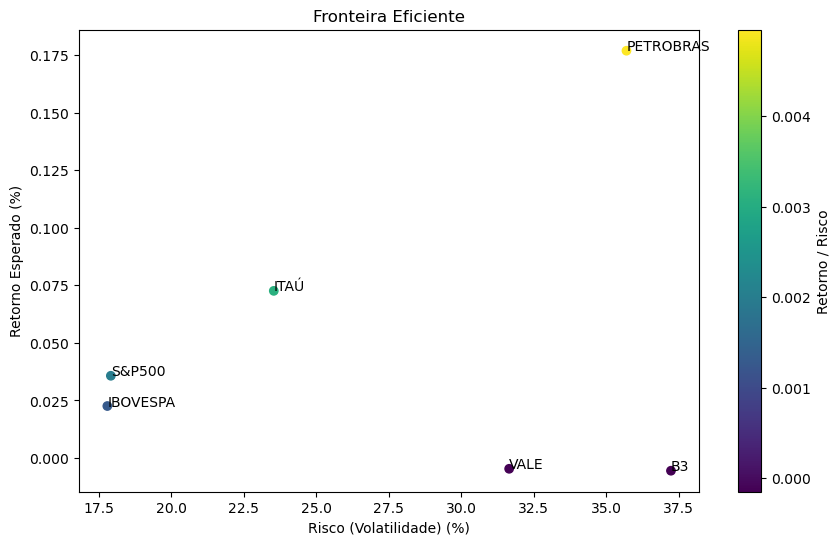

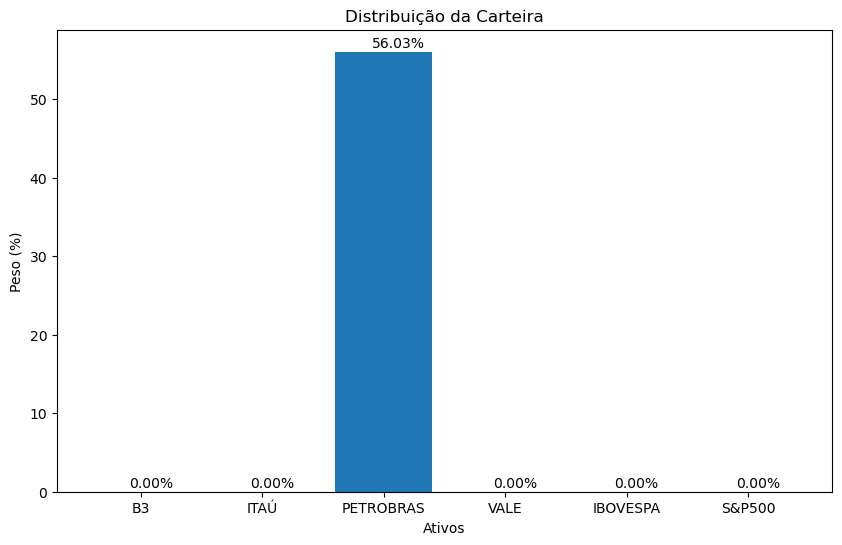

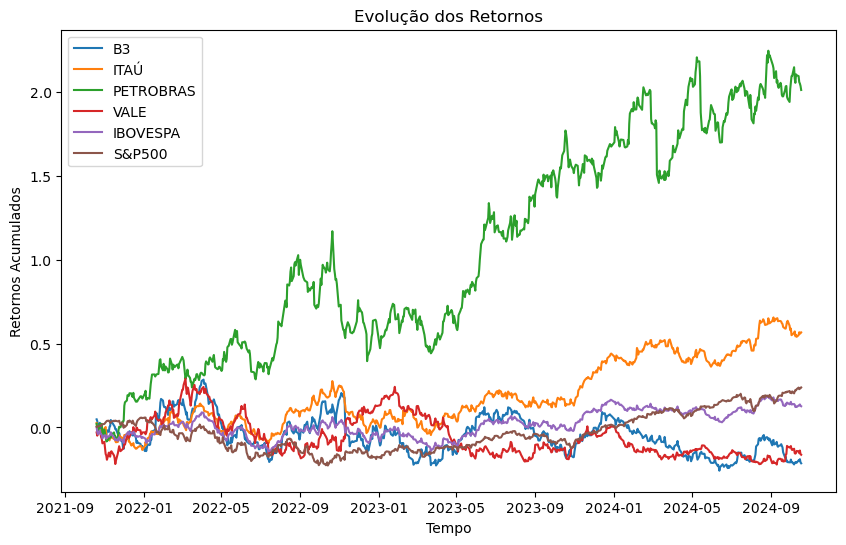

In [8]:
# Fronteira eficiente
plt.figure(figsize=(10, 6))
plt.scatter(volatilidade * 100, retornos.mean() * 100, c=(retornos.mean() / volatilidade), marker='o')
for i, txt in enumerate(dados_mercado.columns):
    plt.annotate(txt, (volatilidade.iloc[i] * 100, retornos.mean().iloc[i] * 100))
plt.xlabel('Risco (Volatilidade) (%)')
plt.ylabel('Retorno Esperado (%)')
plt.title('Fronteira Eficiente')
plt.colorbar(label='Retorno / Risco')
plt.show()

# Alocação dos Pesos
plt.figure(figsize=(10, 6))
bars = plt.bar(dados_mercado.columns, pesos_percent)
plt.xlabel('Ativos')
plt.ylabel('Peso (%)')
plt.title('Distribuição da Carteira')
# Adicionar os valores das porcentagens acima das colunas
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.5, f'{yval:.2f}%')

plt.show()

# Evolução dos Retornos
retornos_acumulados = (1 + retornos).cumprod() - 1
plt.figure(figsize=(10, 6))
plt.plot(retornos_acumulados)
plt.xlabel('Tempo')
plt.ylabel('Retornos Acumulados')
plt.title('Evolução dos Retornos')
plt.legend(dados_mercado.columns)
plt.show()